[View in Colaboratory](https://colab.research.google.com/github/rdenadai/dsp_study_notebooks/blob/master/notebooks/dsp101d.ipynb)

## DSP 101d

Experiments on Digital Signal Processing, ranging from random generated signals, voice and images!

In these experiments, we are not analysing signals in the range of DSP but also with an statistical view...

To build this document we use a lot of resources, here are some of the most important.
- References:
 - [DSP Guide](http://www.dspguide.com)
 - [Understand the Fourier transform and its applications](https://www.udemy.com/fourier-transform-mxc/)
 - [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy)
 - [DSP Tutorial](https://www.tutorialspoint.com/digital_signal_processing/index.htm)
 - [Plotly FFT Filters](https://plot.ly/python/fft-filters/)
 - [Digital Signal Processing {youtube}](https://www.youtube.com/playlist?list=PLuh62Q4Sv7BUSzx5Jr8Wrxxn-U10qG1et)
 - [Signal Processing 101 {youtube}](https://www.youtube.com/watch?v=KZd68xgasIU&list=PLJ-OcUCIty7evBmHvYRv66RcuziszpSFB)
 - [All Signal Processing {youtube}](https://www.youtube.com/user/allsignalprocessing/playlists)


In [0]:
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import resample
from scipy import interpolate
from scipy import signal
from scipy import fftpack
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import Audio

%matplotlib inline

def normalization(x, m=255):
    return (((x - min(x)) / (max(x) - min(x))) * m).astype('int64')

def normalization2(x, a, b):
    return (a + (((x - min(x)) * (b - a)) / (max(x) - min(x)))).astype('float64')

def sine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.sin((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def cosine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.cos((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def complex_wave(A=1, f=1, t=1, Fs=1024, phi=0):
    n = np.arange(Fs * t)
    return (A * np.exp((((2 * np.pi * f) * n) / Fs) * 1j + phi))

## Frequency Resolution

> *"**Frequency resolution is the distance in Hz between two adjacent data points in the DFT**. The frequency resolution of a DFT is defined as $\frac{F_s}{N}$. Where $F_s$ is the sampling rate and $N$ is the number of data points. The denominator can be expressed in terms of sampling rate and time, $N=F_st$. In other words, **the only thing that increases frequency resolution is time**. Changes in sampling rate do nothing towards increasing the frequency resolution if the actual time span of your signal is the same. By increasing the sampling rate, you're only increasing the frequency coverage. Your frequency axis will span more values, but they will be spaced the same distance in Hz as the lower sampling rate.
"* [Quora](http://qr.ae/TUI1Mf)

Frequencies X1[n]:  [3.  3.5]
Frequencies X2[n]:  [ 5.   9.8 10.2]


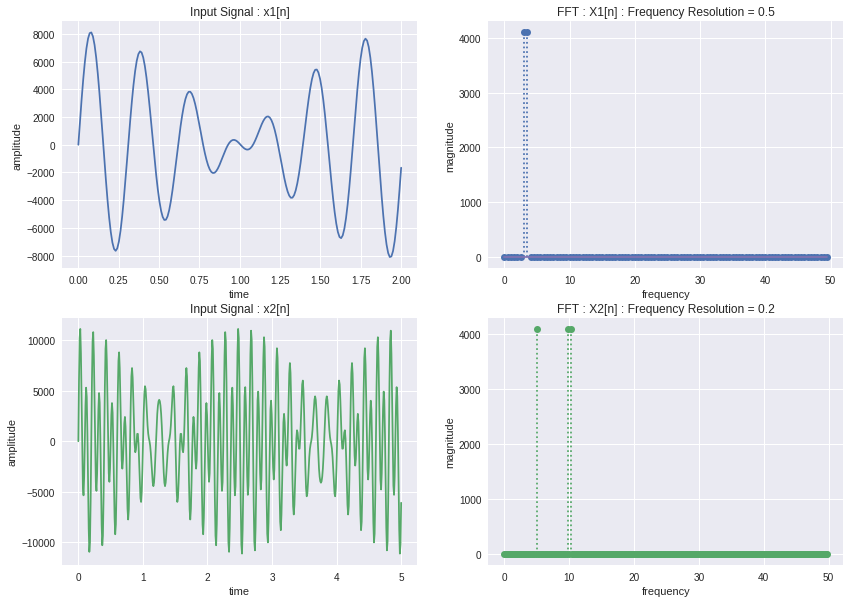

In [232]:
def frequency_resolution(x, t):
    Fs = int(x.size / t)
    X = fftpack.fft(x)
    nyquist = int(x.size / 2)
    time = np.linspace(0, t, Fs * t)
    freqs = (fftpack.fftfreq(x.size) * Fs).astype('float32')
    mag = 2 * (np.abs(X) / x.size)
    return x, mag[:nyquist], time, freqs[:nyquist]

Fs = 100

t = 2
x1 = sine(f=3, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=3.5, t=t, Fs=Fs, dtype=np.float32)
x1, X1, time1, freqs1 = frequency_resolution(x1, t)
res1 = Fs/x1.size
print('Frequencies X1[n]: ', np.where(X1 > 10)[0] * res1)

t = 5
x2 = sine(f=5, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=9.8, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=10.2, t=t, Fs=Fs, dtype=np.float32)
x2, X2, time2, freqs2 = frequency_resolution(x2, t)
res2 = Fs/x2.size
print('Frequencies X2[n]: ', np.where(X2 > 10)[0] * res2)

plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {res1}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C1')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {res2}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.show()

### Zero-padding in Time Domain

"*Zero padding in time domain correspond to ideal interpolation in the frequency domain.*" [JOS CCRMA Stanford](https://ccrma.stanford.edu/~jos/sasp/Zero_Padding_Time_Domain.html)

"*Sometimes people will say that zero-padding in the time domain yields higher spectral resolution in the frequency domain. However, signal processing practitioners should not say that, because 'resolution' in signal processing refers to the ability to 'resolve' closely spaced features in a spectrum analysis. The usual way to increase spectral resolution is to **take a longer DFT without zero padding**...*" [JOS CCRMA Stanford](https://ccrma.stanford.edu/~jos/mdft/Zero_Padding_Applications.html)

Besides the above citation observes the correct way to implement better frequency resolution, the bellow example shows the use of zero padding in time domain, in a certain way improve frequency resolution.


In [0]:
def zero_padding_time_domain(x, resolution=40):
    """
        This function does not work quite well with sinewaves because
        calculation of time and frequency are not entirelly correct.
    """
    Fs = x.size
    res = int(np.ceil(resolution))
    t = Fs + res
    nyquist = int(t/2)
    time = np.linspace(0, 1, t)
    freqs = (fftpack.fftfreq(t) * Fs).astype('float32')
    # In this line we are actually doing the zero padding at end
    x = np.append(x, np.zeros(res))
    X = 2 * np.abs(fftpack.fft(x)) / x.size
    return x, X[:nyquist], time, freqs[:nyquist]

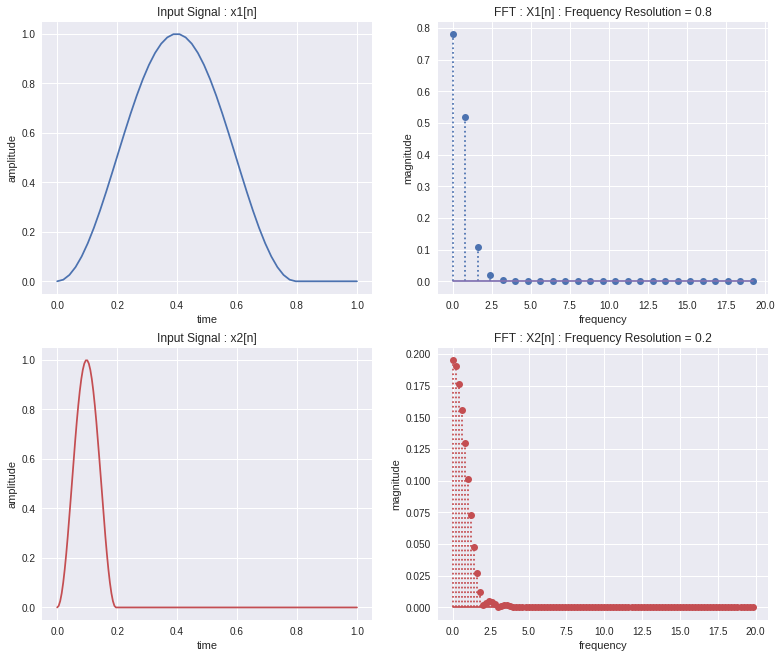

In [153]:
Fs = 40
x1 = np.hanning(Fs)
x1, X1, time1, freqs1 = zero_padding_time_domain(x1, 10)

x2 = np.hanning(Fs)
x2, X2, time2, freqs2 = zero_padding_time_domain(x2, Fs * 4)

plt.figure(figsize=(13, 11))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {Fs/x1.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C2')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {Fs/x2.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C2:', markerfmt='C2o', basefmt='C2')
plt.show()